# 데이터 관련

In [1]:
# import modules
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import models, transforms

import matplotlib.pyplot as plt
import random
import time
import os

import numpy as np

###  Google Drive Mount

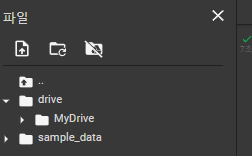

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Unzip dataset
- 구글 드라이브에 데이터를 저장할 시 I/O 병목으로 인해 train 속도가 느릴 수 있습니다.
- 코랩의 content 디렉토리 아래에 데이터의 압축을 풀어 사용하시기 바랍니다

In [3]:
# unzip train, valid dataset
# target 을 정하지 않으면 google drive 내의 content 드라이브에 위치시킴
# 런타임을 다시 시작할 때 마다 unzip 을 새로 해주어야 함.
!unzip /content/gdrive/MyDrive/2023_EEE4178_project/train.zip
!unzip /content/gdrive/MyDrive/2023_EEE4178_project/valid.zip
# !unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_test.zip

Archive:  /content/gdrive/MyDrive/2023_EEE4178_project/train.zip
replace train/30/395_30.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/gdrive/MyDrive/2023_EEE4178_project/valid.zip
replace valid/30/244_30.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Custom dataset & dataloader

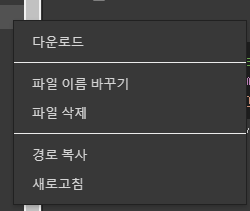

In [4]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

class MyDataset(Dataset):
    def __init__(self, npy_dir, label_dict=None):
        self.dir_path = npy_dir
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.transpose(0, 1)),
            transforms.Lambda(lambda x: TF.rotate(x, -90))
        ])
        self.npy_path = glob.glob(os.path.join(npy_dir, '*', '*.npy'))
        self.label_dict = label_dict or self.create_label_dict()

    def create_label_dict(self):
        label_dict = {}
        for path in self.npy_path:
            label_name = os.path.basename(os.path.dirname(path))
            if label_name not in label_dict:
                label_dict[label_name] = len(label_dict)
        return label_dict

    def __getitem__(self, index):
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)

        image = data['image']
        image = self.to_tensor(image)
        image = TF.hflip(image)

        label_name = os.path.basename(os.path.dirname(single_data_path))
        label = self.label_dict[label_name]
        label = torch.tensor(label, dtype=torch.long)

        return (image, label)

    def __len__(self):
        return len(self.npy_path)

label_dict = {
    '30': 0, '31': 1, '32': 2, '33': 3, '34': 4, '35': 5, '36': 6, '37': 7, '38': 8, '39': 9,
    '41': 10, '42': 11, '43': 12, '44': 13, '45': 14, '46': 15, '47': 16, '48': 17, '49': 18,
    '4a': 19, '4b': 20, '4c': 21, '4d': 22, '4e': 23, '50': 24, '51': 25, '52': 26, '53': 27,
    '54': 28, '55': 29, '56': 30, '57': 31, '58': 32, '59': 33, '5a': 34, '61': 35, '62': 36,
    '64': 37, '65': 38, '66': 39, '67': 40, '68': 41, '69': 42, '6a': 43, '6d': 44, '6e': 45,
    '6f': 46, '71': 47, '72': 48, '74': 49, '75': 50, '79': 51,
}

# unzip 한 디렉토리 있는 path 그대로 넣어야, 디렉토리 옆 점 3개 누르면 '경로 복사' 있음 - 위의 사진 참조
train_data = MyDataset("/content/train", label_dict)
valid_data = MyDataset("/content/valid", label_dict)

print(len(train_data))
print(len(valid_data))

41600
15600


In [5]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           shuffle=True)

# check dataloader
image,label = next(iter(valid_loader))
print(image.shape)
print(label.shape)

torch.Size([50, 1, 100, 100])
torch.Size([50])


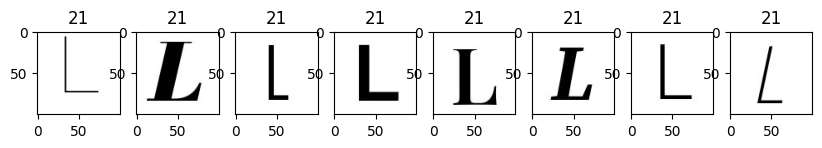

In [6]:
# visualize data
# image_show function : num 수 만큼 dataset 내의 data를 보여주는 함수
def image_show(dataset, num):
  fig = plt.figure(figsize=(10,10))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i+12200][0].squeeze(), cmap="gray")
    plt.title(dataset[i+12200][1].item())  # .item()을 사용하여 텐서에서 숫자로 변환

image_show(train_data, 8)

#학습 환경 관련


### Check GPU Configuration

In [7]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Fri Dec 15 07:39:49 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Fix seed
42로 Seed를 고정하여 사용하시기 바랍니다.

In [8]:
# FIX SEED
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

In [10]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

# Adjust Model Structure Depends on the Data
num_classes = 52  # 0~51 : 52 classes
in_channel = 1    # 흑백 이미지이니 in_channel은 1

# Hyper-parameters
batch_size = 50
learning_rate = 0.0001
num_epochs = 12

device: cuda


In [27]:
class ConvNet(nn.Module):
  def __init__(self, num_classes=52):
    super(ConvNet, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, 5, 1, 2), # 1x100x100 --> 32x100x100
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # 32x100x100 --> 32x50x50
    )
    self.layer2 = nn.Sequential( # 32x50x50 --> 64x50x50
        nn.Conv2d(32, 16, 1, 1, 0), # Bottleneck layer(차원 축소)
        nn.BatchNorm2d(16),
        nn.ReLU(),

        nn.Conv2d(16, 16, 5, 1, 2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16, 64, 1, 1, 0),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # 64x25x25
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(64, 32, 1, 1, 0),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(32, 32, 5, 1, 2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 128, 1, 1, 0),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=5) # 128x5x5
    )
    self.fc1 = nn.Linear(128*5*5, 100)
    self.fc2 = nn.Linear(100, num_classes)

    self.dropout = nn.Dropout(0.4)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = x.reshape(x.size(0), -1)

    x = self.dropout(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = F.relu(x)

    return x

In [28]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer 이용

In [29]:
total_step = len(train_loader)
total_loss = []
model.train() # train 모드로 지정

start = time.time() # Train 시작 시간 정보 저장
for epoch in range(num_epochs): # 에폭만큼 반복, 각 에폭에 대해서 --> epoch별 반복문
  epoch_loss = []
  for i, (img, label) in enumerate(train_loader): # batch를 하나씩 불러오면서 --> batch별 반복문
    # Assign Tensors to Configures Devices (gpu)
    img = img.to(device)
    label = label.to(device)

    # Forward propagation
    outputs = model(img)

    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs, label) # loss 계산
    optimizer.zero_grad() # gradient 초기화
    loss.backward() # backpropagation 계산
    optimizer.step() # gradient 업데이트

    epoch_loss.append(loss.detach().cpu().numpy())
    # Print Loss
    if (i+1)==len(train_loader):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
  total_loss.append(np.mean(epoch_loss))
  print(f"epoch{epoch+1} loss: {np.mean(epoch_loss)}") # loss가 점점 줄어드는 것을 확인할 수 있다

end = time.time() # Train 종료 시간 정보 저장
duration = end - start # 종료 시간 - 시작 시간
print("Training takes {:.2f}minutes".format(duration/60)) #초 단위로 저장되므로, 60으로 나누어 분으로 표시
torch.save(model.state_dict(), 'model.pth')

Epoch [1/12], Step [832/832], Loss: 1.0362
epoch1 loss: 2.3649892807006836
Epoch [2/12], Step [832/832], Loss: 0.5041
epoch2 loss: 0.644256591796875
Epoch [3/12], Step [832/832], Loss: 0.7406
epoch3 loss: 0.38396379351615906
Epoch [4/12], Step [832/832], Loss: 0.3293
epoch4 loss: 0.27926933765411377
Epoch [5/12], Step [832/832], Loss: 0.1869
epoch5 loss: 0.22626471519470215
Epoch [6/12], Step [832/832], Loss: 0.1335
epoch6 loss: 0.19391189515590668
Epoch [7/12], Step [832/832], Loss: 0.2079
epoch7 loss: 0.17027083039283752
Epoch [8/12], Step [832/832], Loss: 0.0703
epoch8 loss: 0.14959894120693207
Epoch [9/12], Step [832/832], Loss: 0.0903
epoch9 loss: 0.13229171931743622
Epoch [10/12], Step [832/832], Loss: 0.1455
epoch10 loss: 0.12563233077526093
Epoch [11/12], Step [832/832], Loss: 0.1247
epoch11 loss: 0.1135103851556778
Epoch [12/12], Step [832/832], Loss: 0.1104
epoch12 loss: 0.10300076752901077
Training takes 13.97minutes


In [30]:
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1

In [32]:
from torchsummary import summary
summary(model, (1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             832
       BatchNorm2d-2         [-1, 32, 100, 100]              64
              ReLU-3         [-1, 32, 100, 100]               0
         MaxPool2d-4           [-1, 32, 50, 50]               0
            Conv2d-5           [-1, 16, 50, 50]             528
       BatchNorm2d-6           [-1, 16, 50, 50]              32
              ReLU-7           [-1, 16, 50, 50]               0
            Conv2d-8           [-1, 16, 50, 50]           6,416
       BatchNorm2d-9           [-1, 16, 50, 50]              32
             ReLU-10           [-1, 16, 50, 50]               0
           Conv2d-11           [-1, 64, 50, 50]           1,088
      BatchNorm2d-12           [-1, 64, 50, 50]             128
             ReLU-13           [-1, 64, 50, 50]               0
        MaxPool2d-14           [-1, 64,

In [31]:
model.eval() # Set model as evaluation mode

with torch.no_grad(): # auto_grad off
  correct = 0
  total = 0
  for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the last_model network on the {} valid images: {} %'.format(len(valid_data), 100 * correct / len(valid_data)))

Accuracy of the last_model network on the 15600 valid images: 98.5448717948718 %


In [ ]:
plt.plot(total_loss)
plt.title("Loss Graph")
plt.show()